# Processed Data

In [1]:
import pandas as pd
import numpy as np
import tqdm
import os

Load data.

In [2]:
from splicevo.utils.data_utils import load_processed_data

# Load data
data_dir = f"/home/elek/sds/sd17d003/Anamaria/splicevo/data/"
subset = "full"

# Load data from per-genome processed files
# genome = "mouse_GRCm38"
# data_path = os.path.join(data_dir, f"processed_{subset}", f"{genome}")

# Load data from train-test split
species = "mouse_rat_human"
data_path = os.path.join(data_dir, f"splits_{subset}", f"{species}", "train")

sequences, labels, alpha, beta, sse, species = load_processed_data(data_path)

# Metadata
meta_fn = os.path.join(data_path, "metadata.json")
with open(meta_fn, "r") as f:
    import json
    meta = json.load(f)

# Test windows metadata
meta_fn = os.path.join(data_path, "metadata.csv")
meta_df = pd.read_csv(meta_fn, dtype={"genome_id": str, "chromosome": str, "window_start": int, "window_end": int, "strand": str})

# Species (if available)
species_name_to_id = meta.get('species_mapping', {})
species_id_to_name = {v: k for k, v in species_name_to_id.items()}

/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Check the structure of meta_df
print("Test metadata columns:")
print(meta_df.columns.tolist())
print("\nTest metadata shape:", meta_df.shape)
print("\nGenomes: ", meta_df['genome_id'].unique())
for genome in meta_df['genome_id'].unique():
    print("\nChromosomes: ")
    print(" ", genome, ": ", meta_df[meta_df['genome_id'] == genome]['chromosome'].unique())

Test metadata columns:
['chromosome', 'gene_id', 'genome_id', 'n_acceptor_sites', 'n_donor_sites', 'strand', 'window_end', 'window_start', 'species_id']

Test metadata shape: (548228, 9)

Genomes:  ['human_GRCh37' 'mouse_GRCm38' 'rat_Rnor_5.0']

Chromosomes: 
  human_GRCh37 :  ['11' '1' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21' '22' '3'
 '4' '5' '6' '7' '8' '10' '9' 'X' 'MT']

Chromosomes: 
  mouse_GRCm38 :  ['12' '1' '13' '14' '15' '16' '17' '18' '19' '3' '10' '5' '6' '7' '8' '9'
 'X' 'MT' '11']

Chromosomes: 
  rat_Rnor_5.0 :  ['12' '1' '13' '14' '15' '16' '17' '18' '19' '2' '20' '3' '4' '5' '6' '7'
 '8' '9' 'X' 'MT' '10' '11']


In [4]:
# Check meta structure
print("Metadata keys:", meta.keys())
print("Species mapping:", meta.get('species_mapping', {}))

window = meta['window_size']
context = meta['context_size']

Metadata keys: dict_keys(['sequences_shape', 'labels_shape', 'sequences_dtype', 'labels_dtype', 'usage_conditions', 'window_size', 'context_size', 'species_ids_dtype', 'species_ids_shape', 'alpha_shape', 'alpha_dtype', 'beta_shape', 'beta_dtype', 'sse_shape', 'sse_dtype', 'species_mapping', 'n_species'])
Species mapping: {'human': 0, 'mouse': 1, 'rat': 2}


## Splice Site Analysis

Extract sequences from genome and examine splice sites.

In [5]:
from splicevo.io.genome import GenomeData
from splicevo.io.gene_annotation import GTFProcessor
from splicevo.utils.sequence_utils import one_hot_encode, one_hot_decode, complement_sequence
import matplotlib.pyplot as plt


# Configuration for genome data
genome_config = {
    "mouse_GRCm38": {
        "genome_path": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/fasta/Mus_musculus.fa.gz",
        "gtf_path": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Mus_musculus.gtf.gz"
    },
    "rat_Rnor_5.0": {
        "genome_path": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/fasta/Rattus_norvegicus.fa.gz",
        "gtf_path": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Rattus_norvegicus.gtf.gz"
    },
    "human_GRCh37": {
        "genome_path": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/fasta/Homo_sapiens.fa.gz",
        "gtf_path": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz",
    }
}

# Initialize genome loaders
try:
    genome_mouse = GenomeData(
        genome_id="mouse_GRCm38",
        genome_path=genome_config["mouse_GRCm38"]["genome_path"],
        gtf_path=genome_config["mouse_GRCm38"]["gtf_path"]
    ).load_genome()
except Exception as e:
    print(f"Warning: Could not load genome FASTA file: {e}")
    genome_mouse = None
try:
    genome_rat = GenomeData(
        genome_id="rat_Rnor_5.0",
        genome_path=genome_config["rat_Rnor_5.0"]["genome_path"],
        gtf_path=genome_config["rat_Rnor_5.0"]["gtf_path"]
    ).load_genome()
except Exception as e:
    print(f"Warning: Could not load genome FASTA file: {e}")
    genome_rat = None
try:
    genome_human = GenomeData(
        genome_id="human_GRCh37",
        genome_path=genome_config["human_GRCh37"]["genome_path"],
        gtf_path=genome_config["human_GRCh37"]["gtf_path"]
    ).load_genome()
except Exception as e:
    print(f"Warning: Could not load genome FASTA file: {e}")
    genome_human = None

# Extract usage conditions from metadata
usage_conditions = meta.get('usage_conditions', [])

Analyze splice sites in selected windows - either by window indices or by genomic coordinates.

In [6]:
from splicevo.utils.analysis_utils import analyze_splice_sites

# Analyze several random sequences
window_indices = np.array([0, 5, 10])
analyze_splice_sites(
    test_seq=sequences,
    test_labels=labels,
    test_meta_df=meta_df,
    test_sse=sse,
    test_alpha=alpha,
    test_beta=beta,
    genome=None,
    window_indices=window_indices,
    usage_conditions=usage_conditions,
    context_size=context
)

SPLICE SITE ANALYSIS


Window 1 (index 0): hum.10006 on chromosome 11 (- strand)
Genome ID: human_GRCh37
Genomic location: 11:18134190-18135190
Donor sites: 0, Acceptor sites: 1

Sequence from processed data (length=1900):
AAATCCGAAGTAATGACTTCAACAAGTATCCTAATAGAATAATAGAAAAGATAAAATACTTGGTATATTAATATCCGAATATCAACCAGGTATAATACCA...

Donor site positions in sequence: []

Acceptor site positions in sequence: [0]
Sequences around acceptor sites (±5bp):
  CGTCCAGCCTTC
       ^^

  Usage patterns at splice sites:
    Acceptor sites:
      Position 0:
        Brain_11: SSE=0.0000
        Brain_12: SSE=0.0000
        Brain_13: SSE=0.0000
        Brain_2: SSE=0.0000
        Brain_3: SSE=0.0000
        Brain_6: SSE=0.0000
        Brain_8: SSE=0.0000
        Cerebellum_10: SSE=0.0000
        Cerebellum_11: SSE=0.0000
        Cerebellum_12: SSE=0.0000
        Cerebellum_13: SSE=0.0000
        Cerebellum_14: SSE=0.0000
        Cerebellum_3: SSE=0.0000
        Cerebellum_4: SSE=0.0000
        Cerebellum_6

In [7]:
from splicevo.utils.analysis_utils import analyze_splice_sites

# Inspect specific human genomic coordinates and extract data for plotting
genomic_targets = [
    ('human_GRCh37', '11', 75150385, 75150399, '-'),  # EDF5
    ('mouse_GRCm38', '5', 124543487, 124543507, '*'), # EDF6
    ('mouse_GRCm38', '19', 32646329, 32646343, '*'),  # EDF7
    ('human_GRCh37', '21', 27369675, 27369731, '-'),  # EDF9
    ('human_GRCh37', '1', 110167925, 110168055, '+'), # EDF10
    #('human_GRCh37', '6', 163835137, 164000670, '+'), # QKI
    #('human_GRCh37', '6', 163984450, 163984500, '+'), # QKI
    #('human_GRCh37', '6', 163986900, 163987850, '+'), # QKI
    #('human_GRCh37', '3', 142740160, 142740259, '+'), # QKI
]
analysis_data = analyze_splice_sites(
    test_seq=sequences,
    test_labels=labels,
    test_meta_df=meta_df,
    test_sse=sse,
    test_alpha=alpha,
    test_beta=beta,
    genome=None,
    usage_conditions=usage_conditions,
    genomic_coords=genomic_targets,
    context_size=context,
    return_data=True,
    verbose = True
)

Found 6 windows overlapping specified coordinates:
  Window 5206: human_GRCh37:11:75150285-75151285 (-)
  Window 72554: human_GRCh37:1:110167901-110168901 (+)
  Window 107934: human_GRCh37:21:27369083-27370083 (-)
  Window 271030: mouse_GRCm38:19:32645876-32646876 (+)
  Window 298733: mouse_GRCm38:5:124543042-124544042 (-)
  Window 298737: mouse_GRCm38:5:124543042-124544042 (+)

SPLICE SITE ANALYSIS


Window 1 (index 5206): hum.11477 on chromosome 11 (- strand)
Genome ID: human_GRCh37
Genomic location: 11:75150285-75151285
Donor sites: 39, Acceptor sites: 40

Sequence from processed data (length=1900):
TTTCCGACACACAACGCCCCTCGTTTCGTCCCTACCCACAATCTCTATCTTACATTTCTTCTCTCTCTTTCTCTACCCTCTCCGTCTCTTTCCATTTGTC...

Filtering splice sites using genomic coordinates...
Filtered donor sites: []
Filtered acceptor sites: []

Donor site positions in sequence: []

Acceptor site positions in sequence: []

Window 2 (index 72554): hum.3042 on chromosome 1 (+ strand)
Genome ID: human_GRCh37
Genomic location

## Splice Site Usage Plots

Visualize SSE (Splice Site Efficiency) usage patterns across tissues and timepoints.

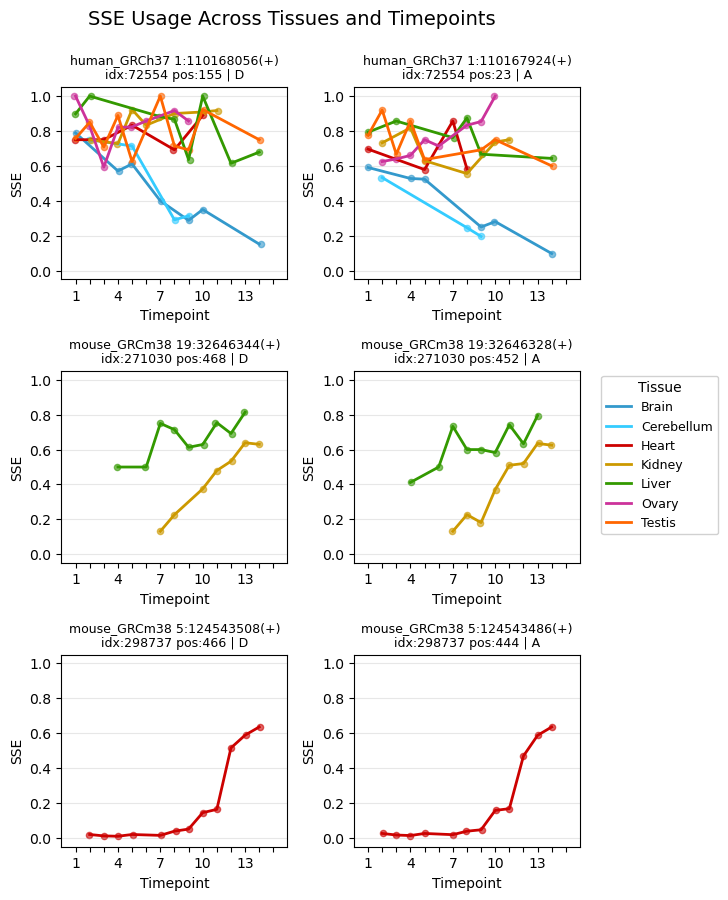

In [9]:
from splicevo.utils.plotting_utils import plot_splice_site_usage

# Colors
tissue_colors = {
    'Brain': '#3399cc',
    'Cerebellum': '#34ccff',
    'Heart': '#cc0100',
    'Kidney': '#cc9900',
    'Liver': '#339900',
    'Ovary': '#cc329a',
    'Testis': '#ff6600'
}

# Plot SSE usage across tissues (lines) and timepoints (x-axis) for all splice sites
if analysis_data:
    ncols = 2
    nrows = int(np.ceil(len(analysis_data) / ncols))
    fig, df = plot_splice_site_usage(
        analysis_data, 
        tissue_colors=tissue_colors,
        figsize = (ncols*3, max([nrows*3, ncols*3])),
        grid_cols = ncols,
        plot_zeroes = False)
    if fig:
        plt.show()